<h1> <center> Será que um professor fica por 2 anos em uma escola? </center> </h1>



<img src='https://media.giphy.com/media/xT5LMpjrnf2Ao4hBMk/giphy.gif'/>




In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import pandas as pd
import re
import numpy as np
from matplotlib import pyplot as plt
import os
from glob import glob
from pathlib import Path
import seaborn as sns
from unicodedata import normalize
from tqdm import tqdm
from scipy import stats
from sklearn import metrics
from tqdm import tqdm

In [2]:
#Arquivos criados para deixar o codigo do notebook mais clean.
from files_util import *
from df_inep_utils import *
from SetorCensitario import *
from modelagem import *

In [ ]:
#alguns numeros ficam muito grandes.
pd.options.display.float_format = '{:.2f}'.format

## <center> Vamos começar a jornada</center>
<img src='https://media.giphy.com/media/fdHg7T902uzLy/giphy.gif'/>

## 01. Obtencao dos dados brutos

In [37]:
#extraindo arquivos baixados
#funcoes de file_utils
shutil.rmtree(ARQ_PATH,ignore_errors=True)
os.mkdir(ARQ_PATH)
list(map(extrai_arq,glob(f'{CSV_PATH}*.zip')));

patool: Extracting /home/itsbarreto/csv/educacao/micro_censo_escolar_2013.zip ...
patool: ... /home/itsbarreto/csv/educacao/micro_censo_escolar_2013.zip extracted to `/home/itsbarreto/csv/educacao/TMP/'.
patool: Extracting /home/itsbarreto/csv/educacao/TMP/2013/DADOS/TURMAS.rar ...
patool: running /usr/bin/unrar x -- /home/itsbarreto/csv/educacao/TMP/2013/DADOS/TURMAS.rar
patool:     with cwd='/home/itsbarreto/csv/educacao/dsc/2013'
patool: ... /home/itsbarreto/csv/educacao/TMP/2013/DADOS/TURMAS.rar extracted to `/home/itsbarreto/csv/educacao/dsc/2013'.
patool: Extracting /home/itsbarreto/csv/educacao/TMP/2013/DADOS/MATRICULA_CO.rar ...
patool: running /usr/bin/unrar x -- /home/itsbarreto/csv/educacao/TMP/2013/DADOS/MATRICULA_CO.rar
patool:     with cwd='/home/itsbarreto/csv/educacao/dsc/2013'
patool: ... /home/itsbarreto/csv/educacao/TMP/2013/DADOS/MATRICULA_CO.rar extracted to `/home/itsbarreto/csv/educacao/dsc/2013'.
patool: Extracting /home/itsbarreto/csv/educacao/TMP/2013/DADOS/ES

## 02. Vamos ver os dados demográficos dos docentes da rede pública?

### Vamos comecar com o Centro Oeste que  é o menor arquivo

In [16]:

def analisa_inicio(dfa):
    re_id_hist = re.compile('(^CO_[A-Z]).+(\D$)')
    cols_hist = [c for c in dfa.columns if re_id_hist.match(c) or c.startswith('NU') or c.startswith('IN') or c in ['TP_NACIONALIDADE','TP_COR_RACA']]
    for c  in cols_hist:
        display(c)
        s = dfa[c]
        if s.nunique() > 10:
            display(s.describe())
        else:
            display(s.value_counts())
        s.hist()
        plt.show();
    display(dfa['TP_SEXO'].value_counts())
    dfa['TP_SEXO'].value_counts().plot.bar();
    plt.show()

df17 = monta_df_docente(f'{ARQ_PATH}/2017/DOCENTES_CO.CSV')
df15 = monta_df_docente(f'{ARQ_PATH}/2015/DOCENTES_CO.CSV')
display(df15.shape)
display(df17.shape)
#dfa17 = monta_df_professores(df17.loc[df17.TP_TIPO_DOCENTE == 1])
print(f'O Centro Oeste possuia em 2015 {df15.loc[df15.TP_TIPO_DOCENTE == 1].CO_PESSOA_FISICA.nunique()} professores.')
print(f'O Centro Oeste possuia em 2017 {df17.loc[df17.TP_TIPO_DOCENTE == 1].CO_PESSOA_FISICA.nunique()} professores.')
#analisa_inicio(dfa17)


NU_ANO_CENSO: int16
CO_PESSOA_FISICA: int64
NU_DIA: int8
NU_MES: int8
NU_ANO: int16
NU_IDADE_REFERENCIA: int8
NU_IDADE: int8
TP_SEXO: int8
TP_COR_RACA: int8
TP_NACIONALIDADE: int8
CO_PAIS_ORIGEM: int16
CO_UF_NASC: float16
CO_MUNICIPIO_NASC: float32
CO_UF_END: float16
CO_MUNICIPIO_END: float32
TP_ZONA_RESIDENCIAL: float16
NU_ANO_CENSO: int16
CO_PESSOA_FISICA: int64
NU_DIA: int8
NU_MES: int8
NU_ANO: int16
NU_IDADE_REFERENCIA: int8
NU_IDADE: int8
TP_SEXO: int8
TP_COR_RACA: int8
TP_NACIONALIDADE: int8
CO_PAIS_ORIGEM: int16
CO_UF_NASC: float16
CO_MUNICIPIO_NASC: float32
CO_UF_END: float16
CO_MUNICIPIO_END: float32
TP_ZONA_RESIDENCIAL: float16


(915093, 135)

(905327, 132)

O Centro Oeste possuia em 2015 164988 professores.
O Centro Oeste possuia em 2017 167113 professores.


<table columns=2 style='width:100%'><tr><td>
<img src='img/profa.jpg'/></td><td> <h2>Professores.</h2></td></tr></table>

In [79]:
cols_prof = ['CO_PESSOA_FISICA','NU_IDADE_REFERENCIA','TP_SEXO',
             'TP_COR_RACA','CO_UF_NASC',
'CO_UF_END',
'TP_ZONA_RESIDENCIAL','IN_POSSUI_NEC_ESPECIAL',
'IN_CEGUEIRA','IN_BAIXA_VISAO',
'IN_SURDEZ','IN_DEF_AUDITIVA',
'IN_SURDOCEGUEIRA','IN_DEF_FISICA',
'IN_DEF_INTELECTUAL','IN_DEF_MULTIPLA',
'TP_ESCOLARIDADE','TP_NORMAL_MAGISTERIO',
'TP_SITUACAO_CURSO_1','CO_AREA_CURSO_1',
'IN_LICENCIATURA_1','IN_COM_PEDAGOGICA_1','TP_TIPO_IES_1',
'TP_SITUACAO_CURSO_2','CO_AREA_CURSO_2',
'IN_LICENCIATURA_2',
'IN_COM_PEDAGOGICA_2','TP_TIPO_IES_2',
'TP_SITUACAO_CURSO_3','CO_AREA_CURSO_3','IN_LICENCIATURA_3',
'IN_COM_PEDAGOGICA_3','TP_TIPO_IES_3',
'IN_ESPECIALIZACAO','IN_MESTRADO',
'IN_DOUTORADO','IN_POS_NENHUM'
]
prof_pbc_df15 = df15.loc[(df15.CO_UF == 53) & (df15.TP_TIPO_CONTRATACAO == 1) & (df15.TP_TIPO_DOCENTE == 1) & (df15.TP_DEPENDENCIA == 2)][cols_prof].drop_duplicates()

In [80]:
display(prof_pbc_df15.shape)
display(prof_pbc_df15.CO_PESSOA_FISICA.nunique())
#prof_pbc_df15.set_index('CO_PESSOA_FISICA',inplace=True)
prof_pbc_df15.head()

(17092, 37)

17092

,CO_PESSOA_FISICA,NU_IDADE_REFERENCIA,TP_SEXO,TP_COR_RACA,CO_UF_NASC,CO_UF_END,TP_ZONA_RESIDENCIAL,IN_POSSUI_NEC_ESPECIAL,IN_CEGUEIRA,IN_BAIXA_VISAO,...,TP_TIPO_IES_2,TP_SITUACAO_CURSO_3,CO_AREA_CURSO_3,IN_LICENCIATURA_3,IN_COM_PEDAGOGICA_3,TP_TIPO_IES_3,IN_ESPECIALIZACAO,IN_MESTRADO,IN_DOUTORADO,IN_POS_NENHUM
9,124187676391,34,1,3,31.00,31.00,1.00,0,-1.00,-1.00,...,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,0.00,0.00,0.00,1.00
29,115161698917,41,2,0,53.00,53.00,1.00,0,-1.00,-1.00,...,2.00,-1.00,-1.00,-1.00,-1.00,-1.00,0.00,0.00,0.00,1.00
34,115111511619,37,2,0,53.00,53.00,1.00,0,-1.00,-1.00,...,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,1.00,0.00,0.00,0.00
43,123820147097,28,2,3,31.00,31.00,1.00,0,-1.00,-1.00,...,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,0.00,0.00,0.00,1.00
44,122777682860,31,1,1,31.00,31.00,1.00,0,-1.00,-1.00,...,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,0.00,0.00,0.00,1.00


In [82]:
a = monta_df_docente(f'{ARQ_PATH}/2014/DOCENTES_CO.CSV')
profs14 = list(set(a.loc[(a.FK_COD_ESTADO == 53) & (a.ID_TIPO_CONTRATACAO == 1) & (a.ID_DEPENDENCIA_ADM == 2)]['FK_COD_DOCENTE'].values))

a = monta_df_docente(f'{ARQ_PATH}/2013/DOCENTES_CO.CSV')
profs13 = list(set(a.loc[(a.FK_COD_ESTADO == 53) & (a.ID_TIPO_CONTRATACAO == 1) & (a.ID_DEPENDENCIA_ADM == 2)]['FK_COD_DOCENTE'].values))
del a

ANO_CENSO: int16
FK_COD_DOCENTE: int64
NU_DIA: int8
NU_MES: int8
NU_ANO: int16
NUM_IDADE_REF_DOCENTE: int8
NUM_IDADE: int8
TP_SEXO: int8
TP_COR_RACA: int8
TP_NACIONALIDADE: int8
FK_COD_PAIS_ORIGEM: int16
FK_COD_ESTADO_DNASC: float16
FK_COD_MUNICIPIO_DNASC: float32
FK_COD_ESTADO_DEND: float16
FK_COD_MUNICIPIO_DEND: float32
ID_ZONA_RESIDENCIAL: int8
ID_POSSUI_NEC_ESPECIAL: int8
ID_CEGUEIRA: int8
ID_BAIXA_VISAO: int8
ID_SURDEZ: int8
ID_DEF_AUDITIVA: int8
ID_SURDOCEGUEIRA: int8
ID_DEF_FISICA: int8
ID_DEF_INTELECTUAL: int8
ID_DEF_MULTIPLA: int8
FK_COD_ESCOLARIDADE: int8
ID_SITUACAO_CURSO_1: float16
FK_CLASSE_CURSO_1: float16
FK_COD_AREA_OCDE_1: object
ID_LICENCIATURA_1: float16
ID_COM_PEDAGOGICA_1: float16
NU_ANO_INICIO_1: float16
NU_ANO_CONCLUSAO_1: float16
ID_TIPO_INSTITUICAO_1: float16
ID_NOME_INSTITUICAO_1: object
FK_COD_IES_1: float32
ID_SITUACAO_CURSO_2: float16
FK_CLASSE_CURSO_2: float16
FK_COD_AREA_OCDE_2: object
ID_LICENCIATURA_2: float16
ID_COM_PEDAGOGICA_2: float16
NU_ANO_INICIO_

In [83]:
cols_drop = []
prof_pbc_df15['IN_MORA_ZONA_URBANA'] = (prof_pbc_df15.TP_ZONA_RESIDENCIAL == 1).astype(np.int8)
cols_drop.append('TP_ZONA_RESIDENCIAL')
prof_pbc_df15['IN_NASCEU_DF'] = (prof_pbc_df15.CO_UF_NASC == 53).astype(np.int8)
cols_drop.append('CO_UF_NASC')
prof_pbc_df15['IN_MORA_DF'] = (prof_pbc_df15.CO_UF_END == 53).astype(np.int8)
cols_drop.append('CO_UF_END')
prof_pbc_df15['IN_MULHER'] = (prof_pbc_df15.TP_SEXO == 2).astype(np.int8)
cols_drop.append('TP_SEXO')
prof_pbc_df15['NU_QTD_GRAD'] = (prof_pbc_df15.TP_SITUACAO_CURSO_1 == 1).astype(np.int8)  + (prof_pbc_df15.TP_SITUACAO_CURSO_2 == 1).astype(np.int8) + (prof_pbc_df15.TP_SITUACAO_CURSO_3 == 1).astype(np.int8)  
cols_drop.append('TP_SITUACAO_CURSO_1')
cols_drop.append('TP_SITUACAO_CURSO_2')
cols_drop.append('TP_SITUACAO_CURSO_3')
prof_pbc_df15['NU_QTD_GRAD_PBC'] = (prof_pbc_df15.TP_TIPO_IES_1 == 1).astype(np.int8)  + (prof_pbc_df15.TP_TIPO_IES_2 == 1).astype(np.int8) + (prof_pbc_df15.TP_TIPO_IES_3 == 1).astype(np.int8)  
prof_pbc_df15['NU_QTD_GRAD_PRIV'] = (prof_pbc_df15.TP_TIPO_IES_1 == 2).astype(np.int8)  + (prof_pbc_df15.TP_TIPO_IES_2 == 2).astype(np.int8) + (prof_pbc_df15.TP_TIPO_IES_3 == 2).astype(np.int8)  
cols_drop.append('TP_TIPO_IES_1')
cols_drop.append('TP_TIPO_IES_2')
cols_drop.append('TP_TIPO_IES_3')
prof_pbc_df15['NU_QTD_LICENCIATURA'] = (prof_pbc_df15.IN_LICENCIATURA_1 == 1).astype(np.int8)  + (prof_pbc_df15.IN_LICENCIATURA_2 == 1).astype(np.int8) + (prof_pbc_df15.IN_LICENCIATURA_3 == 1).astype(np.int8)  
cols_drop.append('IN_LICENCIATURA_1')
cols_drop.append('IN_LICENCIATURA_2')
cols_drop.append('IN_LICENCIATURA_3')
prof_pbc_df15['NU_QTD_COM_PEDAGOGICA'] = (prof_pbc_df15.IN_COM_PEDAGOGICA_1 == 1).astype(np.int8)  + (prof_pbc_df15.IN_COM_PEDAGOGICA_2 == 1).astype(np.int8) + (prof_pbc_df15.IN_COM_PEDAGOGICA_3 == 1).astype(np.int8)  
cols_drop.append('IN_COM_PEDAGOGICA_1')
cols_drop.append('IN_COM_PEDAGOGICA_2')
cols_drop.append('IN_COM_PEDAGOGICA_3')
prof_pbc_df15['IN_NOVATO'] = (~prof_pbc_df15.CO_PESSOA_FISICA.isin(profs13) & ~prof_pbc_df15.CO_PESSOA_FISICA.isin(profs14)).astype(np.int8)   



In [84]:
prof_pbc_df15.drop(cols_drop,axis=1,inplace=True)

In [85]:
display(prof_pbc_df15.shape)
prof_pbc_df15.head()

(17092, 31)

,CO_PESSOA_FISICA,NU_IDADE_REFERENCIA,TP_COR_RACA,IN_POSSUI_NEC_ESPECIAL,IN_CEGUEIRA,IN_BAIXA_VISAO,IN_SURDEZ,IN_DEF_AUDITIVA,IN_SURDOCEGUEIRA,IN_DEF_FISICA,...,IN_MORA_ZONA_URBANA,IN_NASCEU_DF,IN_MORA_DF,IN_MULHER,NU_QTD_GRAD,NU_QTD_GRAD_PBC,NU_QTD_GRAD_PRIV,NU_QTD_LICENCIATURA,NU_QTD_COM_PEDAGOGICA,IN_NOVATO
9,124187676391,34,3,0,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,...,1,0,0,0,1,0,1,1,0,1
29,115161698917,41,0,0,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,...,1,1,1,1,2,0,2,2,0,0
34,115111511619,37,0,0,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,...,1,1,1,1,1,1,0,1,0,0
43,123820147097,28,3,0,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,...,1,0,0,1,1,0,1,1,0,1
44,122777682860,31,1,0,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,...,1,0,0,0,1,0,1,1,0,1


'CO_PESSOA_FISICA'

count          17092.00
mean    118242040759.29
std       3753540710.39
min     110045177189.00
25%     115115134337.00
50%     116682802030.00
75%     121174247125.25
max     128411329940.00
Name: CO_PESSOA_FISICA, dtype: float64

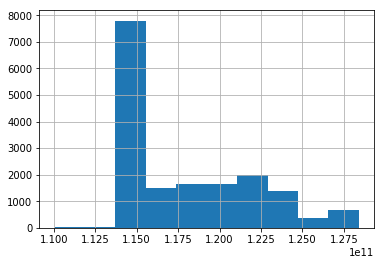

'NU_IDADE_REFERENCIA'

count   17092.00
mean       41.81
std         8.55
min        17.00
25%        36.00
50%        42.00
75%        48.00
max        69.00
Name: NU_IDADE_REFERENCIA, dtype: float64

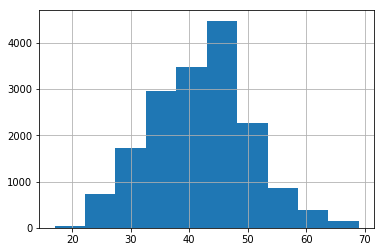

'TP_COR_RACA'

0    5824
1    5412
3    4991
2     756
4      90
5      19
Name: TP_COR_RACA, dtype: int64

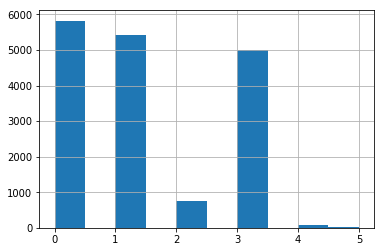

'IN_POSSUI_NEC_ESPECIAL'

0    16916
1      176
Name: IN_POSSUI_NEC_ESPECIAL, dtype: int64

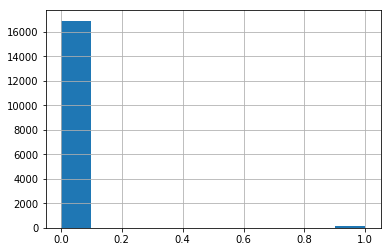

'IN_CEGUEIRA'

-1.00    16916
0.00       164
1.00        12
Name: IN_CEGUEIRA, dtype: int64

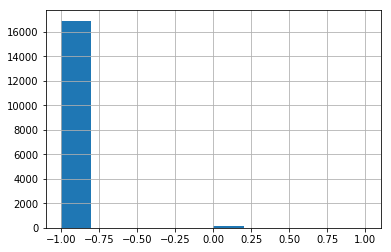

'IN_BAIXA_VISAO'

-1.00    16916
0.00       138
1.00        38
Name: IN_BAIXA_VISAO, dtype: int64

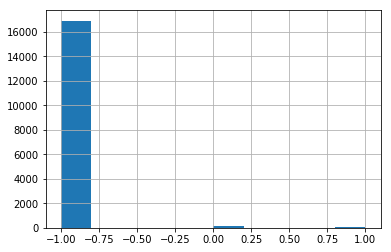

'IN_SURDEZ'

-1.00    16916
0.00       171
1.00         5
Name: IN_SURDEZ, dtype: int64

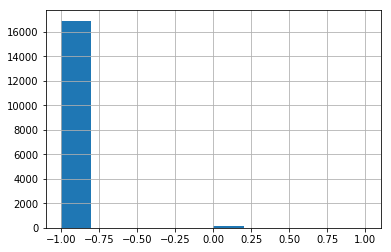

'IN_DEF_AUDITIVA'

-1.00    16916
0.00       151
1.00        25
Name: IN_DEF_AUDITIVA, dtype: int64

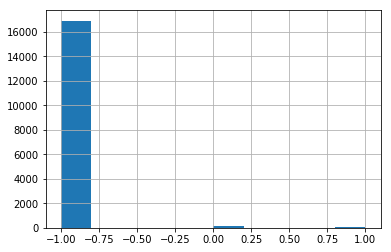

'IN_SURDOCEGUEIRA'

-1.00    16916
0.00       176
Name: IN_SURDOCEGUEIRA, dtype: int64

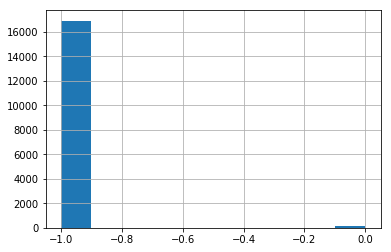

'IN_DEF_FISICA'

-1.00    16916
1.00        98
0.00        78
Name: IN_DEF_FISICA, dtype: int64

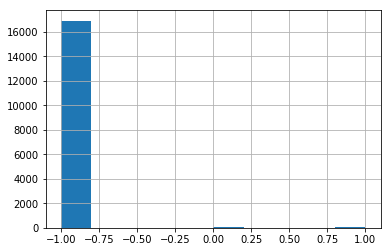

'IN_DEF_INTELECTUAL'

-1.00    16916
0.00       176
Name: IN_DEF_INTELECTUAL, dtype: int64

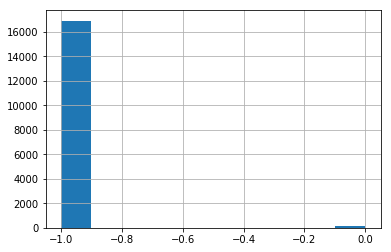

'IN_DEF_MULTIPLA'

-1.00    16916
0.00       174
1.00         2
Name: IN_DEF_MULTIPLA, dtype: int64

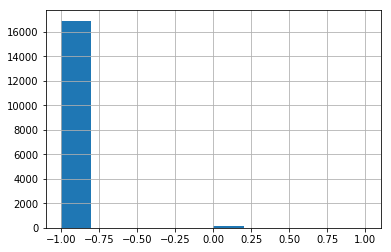

'TP_ESCOLARIDADE'

4    16626
3      464
2        1
1        1
Name: TP_ESCOLARIDADE, dtype: int64

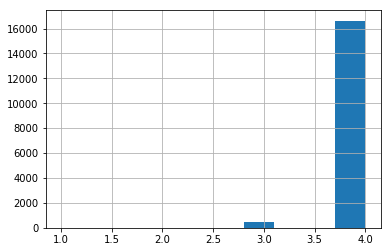

'TP_NORMAL_MAGISTERIO'

3.00     16737
1.00       278
0.00        73
-1.00        2
2.00         2
Name: TP_NORMAL_MAGISTERIO, dtype: int64

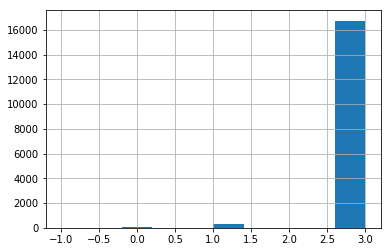

'IN_ESPECIALIZACAO'

1.00     8919
0.00     7707
-1.00     466
Name: IN_ESPECIALIZACAO, dtype: int64

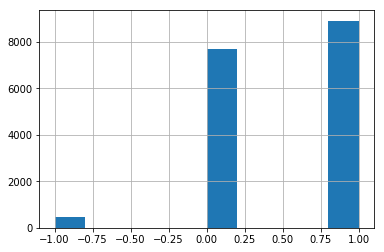

'IN_MESTRADO'

0.00     16060
1.00       566
-1.00      466
Name: IN_MESTRADO, dtype: int64

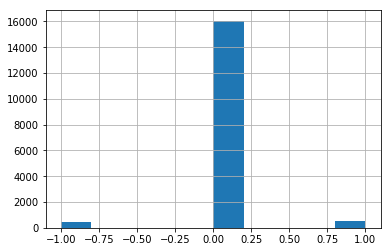

'IN_DOUTORADO'

0.00     16574
-1.00      466
1.00        52
Name: IN_DOUTORADO, dtype: int64

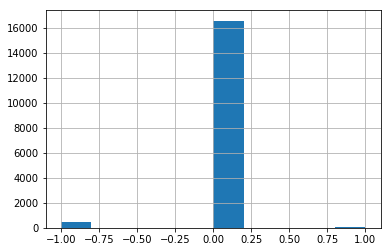

'IN_POS_NENHUM'

0.00     9347
1.00     7279
-1.00     466
Name: IN_POS_NENHUM, dtype: int64

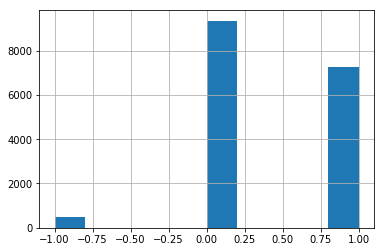

'IN_MORA_ZONA_URBANA'

1    16149
0      943
Name: IN_MORA_ZONA_URBANA, dtype: int64

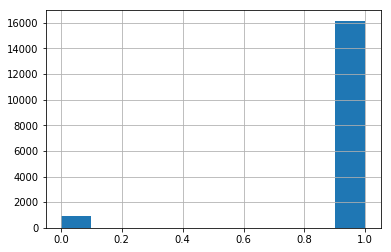

'IN_NASCEU_DF'

1    8757
0    8335
Name: IN_NASCEU_DF, dtype: int64

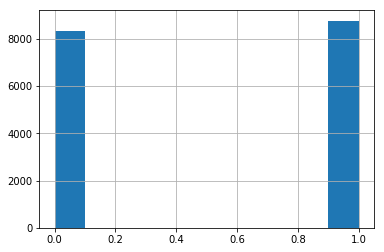

'IN_MORA_DF'

1    12070
0     5022
Name: IN_MORA_DF, dtype: int64

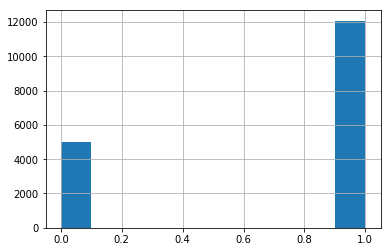

'IN_MULHER'

1    12766
0     4326
Name: IN_MULHER, dtype: int64

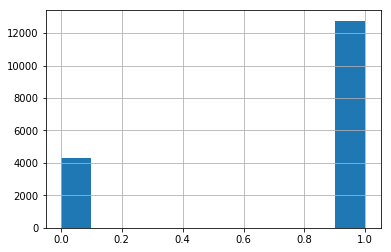

'NU_QTD_GRAD'

1    16099
2      500
0      466
3       27
Name: NU_QTD_GRAD, dtype: int64

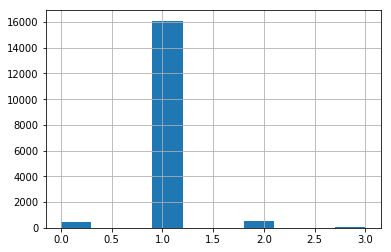

'NU_QTD_GRAD_PBC'

1    8835
0    8101
2     151
3       5
Name: NU_QTD_GRAD_PBC, dtype: int64

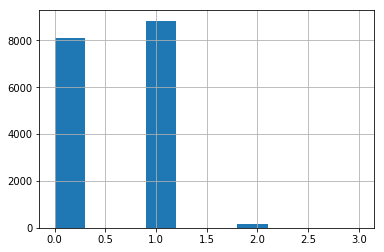

'NU_QTD_GRAD_PRIV'

0    9147
1    7738
2     199
3       8
Name: NU_QTD_GRAD_PRIV, dtype: int64

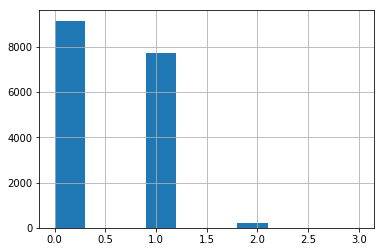

'NU_QTD_LICENCIATURA'

1    14250
0     2570
2      263
3        9
Name: NU_QTD_LICENCIATURA, dtype: int64

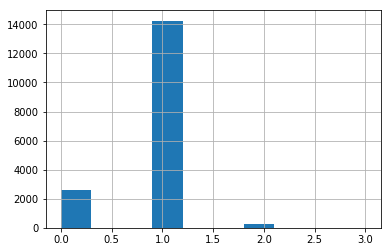

'NU_QTD_COM_PEDAGOGICA'

0    15108
1     1969
2       15
Name: NU_QTD_COM_PEDAGOGICA, dtype: int64

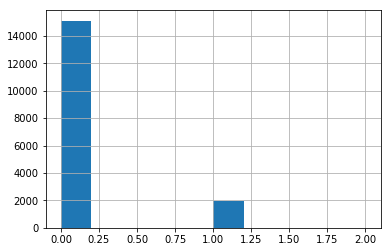

'IN_NOVATO'

0    13720
1     3372
Name: IN_NOVATO, dtype: int64

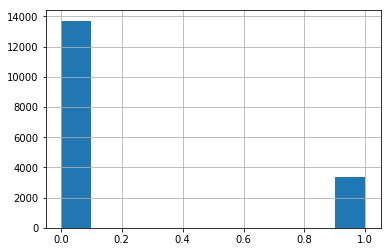

In [86]:
for c in prof_pbc_df15.columns:
    if not c.startswith('CO_CURSO') and not c.startswith('CO_AREA_CURSO'): 
        display(f'{c}')
        if len(list(set(prof_pbc_df15[c].values))) > 10:
            display(prof_pbc_df15[c].describe())
        else:
            display(prof_pbc_df15[c].value_counts())
            
        prof_pbc_df15[c].hist()
        plt.show()

In [ ]:
prof_df.to_csv(f'{PATH_DF_CSV}prof_df.csv',index=False)
pss_ano.to_csv(f'{PATH_DF_CSV}pessoas_prof_df.csv',index=False)

<table columns=2 style='width:100%'><tr><td>
<img src='img/cp_icon.png'/></td><td> <h2>Check-point, recarregando os DataFrames para analisar a situacao do DF e montar a target.</h2></td></tr></table>

In [ ]:
prof_df = pd.read_csv(f'{PATH_DF_CSV}prof_df.csv',low_memory=False)
pss_ano= pd.read_csv(f'{PATH_DF_CSV}pessoas_prof_df.csv',low_memory=False)

In [ ]:
display(pss_ano.reset_index().ANO.value_counts())
pss_ano.shape

In [ ]:
pss_ano.reset_index(inplace=True)
pss_ano = ajusta_colunas_int_df_inep(pss_ano,vai_printar_cols=False)

#### Curiosidade para ver o comportamento das variaveis

In [ ]:
for c in pss_ano.columns[2:]:
    if not c.startswith('CO'):
        for a in anos_pesquisa:
            display(a + ' - ' + c)
            if c.startswith('NU'):
                display(pss_ano.loc[pss_ano.ANO == int(a)][c].describe())
                pss_ano.loc[pss_ano.ANO == int(a)][c].hist()
            else:
                display(pss_ano.loc[pss_ano.ANO == int(a)][c].value_counts())
                pss_ano.loc[pss_ano.ANO == int(a)][c].value_counts().plot.bar()
            plt.show()
            #sns.barplot()
    


### Taxa de rotatividade de professores entre 2 anos .  




In [ ]:
def monta_saidas(pt, ano,turmas=[]):
    pe_ano = pt.loc[(pt.TP_DEPENDENCIA < 4) & (pt.ANO == int(ano)) & ((len(turmas)==0) | (pt.CO_ENTIDADE.isin(turmas)))][['CO_PESSOA_FISICA','CO_ENTIDADE']].drop_duplicates()
    pe_fut = pt.loc[(pt.TP_DEPENDENCIA < 4) & ((len(turmas)==0) | (pt.CO_ENTIDADE.isin(turmas))) & (pt.ANO == int(anos_pesquisa[anos_pesquisa.index(str(ano))+1])) & pt.CO_PESSOA_FISICA.isin(pe_ano.CO_PESSOA_FISICA.unique())][['CO_PESSOA_FISICA','CO_ENTIDADE']].drop_duplicates()
    pe_ano = pe_ano.loc[pe_ano.CO_PESSOA_FISICA.isin(pe_fut.CO_PESSOA_FISICA.unique())]
    to = pe_ano.merge(pe_fut,indicator=True,on=['CO_PESSOA_FISICA','CO_ENTIDADE'],how='outer')
    #vamos manter somente as escolas que estavam abertas nos 2 periodos
    to = to.loc[to._merge =='left_only']
    return to[['CO_PESSOA_FISICA','CO_ENTIDADE']],pe_ano,pe_fut


In [ ]:

for ano in anos_pesquisa[:-1]:
    t,a,f = monta_saidas(prof_df,ano)
    p = t.shape[0]/a.shape[0] * 100
    display(f'{ano}/{int(ano)+2} havia {a.shape[0]} professores/escola, houve {t.shape[0]} saidas ({p}%)');


### Como  o turnover total foi estável no período iremos modelar somente com o biênio 2015/2017

##### Importando dados de escolas e turmas de escolas publicas em funcionamento do DF

In [ ]:
def imp_esc_dist_atv_df(ano):
    d_esc = pd.read_csv(f'{ARQ_PATH}{ano}/ESCOLAS.CSV',sep='|',encoding='latin1',low_memory=False)
    d_esc.fillna(-1,inplace=True)
    d_esc = ajusta_colunas_int_df_inep(d_esc,vai_printar_cols=False)
    d_esc['ANO'] = ano
    return d_esc.loc[(d_esc.CO_UF == 53) & (d_esc.TP_SITUACAO_FUNCIONAMENTO == 1) & (d_esc.TP_DEPENDENCIA == 2)]

escolas = imp_esc_dist_atv_df(2017).append(imp_esc_dist_atv_df(2015))

escolas.head()

In [ ]:
def imp_turma_esc_atv_df(ano,escolas):
    d_tur = pd.read_csv(f'{ARQ_PATH}{ano}/TURMAS.CSV',sep='|',encoding='latin1',low_memory=False)
    d_tur.fillna(-1,inplace=True)
    d_tur = ajusta_colunas_int_df_inep(d_tur,vai_printar_cols=False)
    d_tur['ANO'] = ano
    return d_tur.loc[(d_tur.CO_ENTIDADE.isin(escolas))]


In [ ]:
turmas = imp_turma_esc_atv_df(2015,escolas.loc[escolas.ANO == 2015].CO_ENTIDADE.unique())\
        .append(imp_turma_esc_atv_df(2017,escolas.loc[escolas.ANO == 2017].CO_ENTIDADE.unique()))

In [ ]:
display(turmas.dtypes)
turmas.head()

In [ ]:
escolas.to_csv(f'{PATH_DF_CSV}escolas_distritais_15_17_func_df.csv',index=False)
turmas.to_csv(f'{PATH_DF_CSV}turmas_df.csv',index=False)

In [ ]:
escolas = pd.read_csv(f'{PATH_DF_CSV}escolas_distritais_15_17_func_df.csv',low_memory=False)
turmas = pd.read_csv(f'{PATH_DF_CSV}turmas_df.csv',low_memory=False)

In [ ]:
#escolas distritais que estavam funcionamento em 2015 e 2017
e17 = escolas.loc[(escolas.ANO == 2017)]['CO_ENTIDADE'].unique()
co_e15_17 = escolas.loc[(escolas.ANO == 2015) & (escolas.CO_ENTIDADE.isin(e17))]['CO_ENTIDADE'].unique()
display(len(e17))
display(len(co_e15_17))

In [ ]:
#turnover 2015 em escolas em funcionamento
ano = 2015
t,a,f = monta_saidas(prof_df,ano,turmas=co_e15_17)
p = t.shape[0]/a.shape[0] * 100
display(f'{ano}/{int(ano)+2} havia {a.shape[0]} professores/escola, houve {t.shape[0]} saidas ({p}%)');


### <center>  Temos publico e temos a target! </center>

<img src='https://media.giphy.com/media/3o6MbkNYWUzAuKmDa8/giphy.gif'>




In [ ]:
a = a.merge(t,on=['CO_ENTIDADE','CO_PESSOA_FISICA'],indicator=True,how='left')
a['target'] = a._merge == 'both'
a.drop('_merge',axis=1,inplace=True)
a['ano'] = 2015
display(a.target.value_counts())


In [ ]:
a.to_csv(f'{PATH_DF_CSV}prof_escola_target.csv',index=False)

In [ ]:
#atalho para montagem do professores
def atalho_prof_df2015():
    a = ajusta_colunas_int_df_inep(carrega_arquivo_docentes(f'{ARQ_PATH}2015/DOCENTES_CO.CSV'))
    a['ANO'] = 2015
    b = ajusta_colunas_int_df_inep(carrega_arquivo_docentes(f'{ARQ_PATH}2017/DOCENTES_CO.CSV'))
    b['ANO'] = 2017
    c = a.append(b)
    c.to_csv(f'{PATH_DF_CSV}prof_df.csv',index=None)
    del a, b
    return c
#prof_df = atalho_prof_df2015()


### Apaga arquivos nao utilizados

In [ ]:
import os
for path, subdirs, files in os.walk(ARQ_PATH):
    for name in files:
        if '_' in name and not name.endswith('_CO.CSV') and name.endswith('CSV'):
            f = os.path.join(path, name)
            !rm -rf {f}    

<table columns=2 style='width:100%'><tr><td><img src='img/cp_icon.png'/>
</td><td> <h2>Check-point, importando os DataFrames para criação de features.</h2></td></tr></table>

In [ ]:
escolas = ajusta_colunas_int_df_inep(pd.read_csv(f'{PATH_DF_CSV}escolas_distritais_15_17_func_df.csv',low_memory=False),vai_printar_cols=False)
turmas = ajusta_colunas_int_df_inep(pd.read_csv(f'{PATH_DF_CSV}turmas_df.csv',low_memory=False),vai_printar_cols=False)
prof_df = ajusta_colunas_int_df_inep(pd.read_csv(f'{PATH_DF_CSV}prof_df.csv',low_memory=False),vai_printar_cols=False)
pss_ano = None
try:
    pss_ano= ajusta_colunas_int_df_inep(pd.read_csv(f'{PATH_DF_CSV}pessoas_prof_df.csv',low_memory=False),vai_printar_cols=False)
except Exception as e:
    print(f'Erro na importacao de pss_ano{e}')
    pass
pet = ajusta_colunas_int_df_inep(pd.read_csv(f'{PATH_DF_CSV}prof_escola_target.csv',low_memory=False),vai_printar_cols=False)

## 02. Criação de features para o estudo

- Localizacao:
    * criminalidade
    * linhas de onibus
    * contexto social (setor censitario)
- Infra da escola
    * situacao da escola
- Turma
    * alunos
    * disciplina da turma x displina de formacao




#### Iremos começar com os dados que já temos (escolas e turmas).

- Selecionando features das escolas, professores e turmas.

In [ ]:
list(map(print,prof_df.columns));


In [ ]:
list(map(print,turmas.columns))
cols_sel = [
    'CO_TIPO_ATIVIDADE_1',    'CO_TIPO_ATIVIDADE_2',    'CO_TIPO_ATIVIDADE_3',
'CO_TIPO_ATIVIDADE_4','CO_TIPO_ATIVIDADE_5','CO_TIPO_ATIVIDADE_6',
'ID_TURMA','IN_AUTONOMIA_ESCOLAR','IN_BRAILLE',
'IN_COMUNICACAO_ALT_AUMENT','IN_CONVENIADA_PP',
'IN_DIA_SEMANA_DOMINGO','IN_DIA_SEMANA_QUARTA',
'IN_DIA_SEMANA_QUINTA','IN_DIA_SEMANA_SABADO',
'IN_DIA_SEMANA_SEGUNDA','IN_DIA_SEMANA_SEXTA',
'IN_DIA_SEMANA_TERCA','IN_DISC_ARTES',
'IN_DISC_ATENDIMENTO_ESPECIAIS','IN_DISC_BIOLOGIA',
'IN_DISC_CIENCIAS','IN_DISC_DIVER_SOCIO_CULTURAL',
'IN_DISC_EDUCACAO_FISICA','IN_DISC_ENSINO_RELIGIOSO',
'IN_DISC_ESTUDOS_SOCIAIS','IN_DISC_EST_SOCIAIS_SOCIOLOGIA',
'IN_DISC_FILOSOFIA','IN_DISC_FISICA',
'IN_DISC_GEOGRAFIA','IN_DISC_HISTORIA',
'IN_DISC_INFORMATICA_COMPUTACAO','IN_DISC_LIBRAS',
'IN_DISC_LINGUA_ESPANHOL','IN_DISC_LINGUA_FRANCES',
'IN_DISC_LINGUA_INDIGENA','IN_DISC_LINGUA_INGLES',
'IN_DISC_LINGUA_OUTRA','IN_DISC_LINGUA_PORTUGUESA',
'IN_DISC_MATEMATICA','IN_DISC_OUTRAS',
'IN_DISC_PEDAGOGICAS','IN_DISC_PROFISSIONALIZANTE',
'IN_DISC_QUIMICA','IN_DISC_SOCIOLOGIA',
'IN_EDUCACAO_INDIGENA','IN_EJA',
'IN_ENRIQ_CURRICULAR','IN_ESPECIAL_EXCLUSIVA',
'IN_INFORMATICA_ACESSIVEL','IN_MAIS_EDUCACAO',
'IN_ORIENTACAO_MOBILIDADE',
'IN_PORT_ESCRITA','IN_PROCESSOS_MENTAIS',
'IN_PROFISSIONALIZANTE','IN_RECURSOS_BAIXA_VISAO',
'IN_REGULAR','IN_SINAIS','IN_SOROBAN','NU_DIAS_ATIVIDADE',
'NU_DURACAO_TURMA','NU_MATRICULAS','TX_HR_INICIAL'
]
ft_turmas = turmas.loc[turmas.ANO == 2015][cols_sel].set_index('ID_TURMA')

qtd_turmas = ft_turmas.shape[0]
dc = []
ft_turmas['IN_MANHA'] = (ft_turmas.TX_HR_INICIAL < 12).astype(np.int8)
ft_turmas['IN_TARDE'] = ((ft_turmas.TX_HR_INICIAL >= 12) & (ft_turmas.TX_HR_INICIAL < 18)).astype(np.int8)
ft_turmas['IN_NOITE'] = (ft_turmas.TX_HR_INICIAL >= 18).astype(np.int8)
dc.append('TX_HR_INICIAL')
display(ft_turmas.shape)
for c in ft_turmas.columns:
    if stats.mode(ft_turmas[c])[1] / qtd_turmas > 0.9:
        dc.append(c)
ft_turmas.drop(dc,axis=1,inplace=True)
display(ft_turmas.head())
display(ft_turmas.shape)

In [ ]:
profs = prof_df.loc[prof_df.ANO == 2015][['CO_PESSOA_FISICA','ID_TURMA','CO_ENTIDADE']]


In [ ]:
display(profs.shape)
a = profs.merge(ft_turmas,on='ID_TURMA')
b = a.groupby(['CO_PESSOA_FISICA','CO_ENTIDADE'])[[c for c in a.columns if c.startswith('IN_') or c.startswith('NU_')]].sum()
b.columns = ['SUM_TURMA_' + c for c in b.columns]

d = a.groupby(['CO_PESSOA_FISICA','CO_ENTIDADE'])[[c for c in a.columns if c.startswith('NU_')]].max()
d.columns = ['MAX_TURMA_' + c for c in d.columns]
e = a.groupby(['CO_PESSOA_FISICA','CO_ENTIDADE'])[[c for c in a.columns if c.startswith('NU_')]].min()
e.columns = ['MIN_TURMA_' + c for c in e.columns]

b = b.merge(d,right_index=True,left_index=True)
prof_escolas = b.merge(e,right_index=True,left_index=True)
del a, b, d, e
display(prof_escolas.shape)
prof_escolas.head()

In [ ]:
#so interessa a situacao da escola no momento de analise da saida
list(map(print,escolas.columns));


In [ ]:
ft_escolas = escolas.loc[escolas.NU_ANO_CENSO == 2015]
ft_escolas['NUM_DD_AULAS'] = (pd.to_datetime(ft_escolas.DT_ANO_LETIVO_TERMINO) - pd.to_datetime(ft_escolas.DT_ANO_LETIVO_INICIO)).dt.days
ft_escolas['NUM_DD_AULAS'].head()
cols_sel =['CO_ENTIDADE','CO_ORGAO_REGIONAL','TP_LOCALIZACAO',
           'TP_OCUPACAO_PREDIO_ESCOLAR','TP_OCUPACAO_GALPAO',
          'TP_ATIVIDADE_COMPLEMENTAR']
ft_escolas = ft_escolas[cols_sel +[c for c in ft_escolas.columns if c.startswith('IN_') or c.startswith('NU')]]
ft_escolas.set_index('CO_ENTIDADE',inplace=True)
#vamos as os indicadores que estao em mais de 90% das escolas.
print(ft_escolas.shape)
cols = ft_escolas.columns
qtd_esc = ft_escolas.shape[0]
dc = []
for c in cols:
    if stats.mode(ft_escolas[c])[1] / qtd_esc > 0.9:
        dc.append(c)
ft_escolas.drop(dc,axis=1,inplace=True)
display(ft_escolas.head())
print(ft_escolas.shape)


In [ ]:
display(ft_escolas.dtypes)

In [ ]:
ft_escolas['PC_SALAS_UTILIZADAS'] = (ft_escolas.NU_SALAS_UTILIZADAS/ft_escolas.NU_SALAS_EXISTENTES)\
                                    .astype(np.float16)
ft_escolas['NU_TTL_MATRICLAS'] = turmas.groupby('CO_ENTIDADE').NU_MATRICULAS.sum()
ft_escolas['NU_PROFESSORES'] = prof_df.groupby('CO_ENTIDADE')['CO_PESSOA_FISICA'].count()
cd = []
for c in ft_escolas.columns:
    if c.startswith('NU_') and c!= 'NU_TTL_MATRICLAS':
        ft_escolas[f'{c}_PER_MATRICULA'] = ft_escolas[c]/ft_escolas['NU_TTL_MATRICLAS']
        cd.append(c)
ft_escolas.drop(c,axis=1,inplace=True)
display(ft_escolas.shape)
display(ft_escolas.head())

In [ ]:
prof_escolas = prof_escolas.reset_index().merge(ft_escolas.reset_index(),on='CO_ENTIDADE').set_index(['CO_PESSOA_FISICA','CO_ENTIDADE'])

In [ ]:
display(prof_escolas.shape)
display(prof_escolas.head())

In [ ]:
model_vars = prof_escolas.reset_index().merge(pet.drop('ano',axis=1),on=['CO_PESSOA_FISICA','CO_ENTIDADE'])

In [ ]:
qtd_esc = model_vars.shape[0]
dc = []
for c in model_vars.columns:
    if stats.mode(model_vars[c])[1] / qtd_esc > 0.9:
        dc.append(c)
    else:
        display(c)
        model_vars[c].hist()
        plt.show()
print(dc)

### Dados de:
01. Alunos que compoe as turmas que o professor da aula.


#### Alunos que compoe as turmas

In [ ]:
a = ajusta_colunas_int_df_inep(carrega_arquivo_inep(f'{ARQ_PATH}2015/MATRICULA_CO.CSV'))

In [ ]:
display(a.shape)
display(a.head(2).T)

In [ ]:
alunos = a.loc[a.CO_ENTIDADE.isin(pet.CO_ENTIDADE.unique()) & a.ID_TURMA.isin(profs.ID_TURMA.unique())]
#del a

In [ ]:
alunos['IN_H0MEM'] = (alunos.TP_SEXO == 1).astype(np.int8)
alunos['IN_TERRA_NATAL'] = alunos.CO_MUNICIPIO_NASC == alunos.CO_MUNICIPIO_END
alunos['IN_ONIBUS'] = alunos.TP_RESPONSAVEL_TRANSPORTE.notna()
alunos = alunos.merge(pd.get_dummies(alunos.TP_COR_RACA,prefix='IN_TP_COR_RACA',dtype=np.int8),right_index=True, left_index=True)
display(alunos.shape)
list(map(print,alunos.columns));

In [ ]:
cols_count = ['CO_PESSOA_FISICA']
cols_soma = [f'IN_TP_COR_RACA_{i}' for i in range(0,6)]
cols_media = ['IN_ONIBUS','IN_TERRA_NATAL','IN_H0MEM','NU_IDADE']

cols_gb = ['CO_ENTIDADE','ID_TURMA']
a = alunos.groupby(cols_gb)
c = a[cols_count].count()
c.columns = [f'ALUNO_COUNT_{col}' for col in c.columns]
s = a[cols_soma].sum()
s.columns = [f'ALUNO_SUM_{col}' for col in s.columns]
m = a[cols_media].mean()
m.columns = [f'ALUNO_MEAN_{col}' for col in m.columns]
turma_alunos = c.merge(s,left_index=True,right_index=True).merge(m,left_index=True,right_index=True)
del a,c,s,m
display(turma_alunos.shape)
display(turma_alunos.head())

In [ ]:
turma_alunos.ALUNO_COUNT_CO_PESSOA_FISICA = turma_alunos.ALUNO_COUNT_CO_PESSOA_FISICA.clip_upper(50)
for c in turma_alunos.columns:
    if c.startswith('ALUNO_SUM_IN'):
        turma_alunos[c] = turma_alunos.clip_upper(50)

#### Dados para cruzar professores com turmas

In [ ]:
p15 = ajusta_colunas_int_df_inep(carrega_arquivo_inep(f'{ARQ_PATH}2015/DOCENTES_CO.CSV'))
p15 = p15.loc[p15.CO_PESSOA_FISICA.isin(pet.CO_PESSOA_FISICA)]


In [ ]:
p15r = monta_df_professores_vs17_resu(p15)


In [ ]:
p15r.reset_index(inplace=True)
p15r.columns = [f'PROF_{c}' for c in p15r.columns ]

In [ ]:
list(map(print,p15r.columns));

In [ ]:
a = turma_alunos.reset_index().merge(profs,on=cols_gb)
a.columns = [c for c in a.columns[:-1]] + ['PROF_CO_PESSOA_FISICA']
b = p15r[['PROF_CO_PESSOA_FISICA','PROF_TP_COR_RACA','PROF_IN_CIDADE_NATAL',\
          'PROF_NUM_TTL_GRAD','PROF_NUM_QTD_ESCOLAS','PROF_NUM_QTD_TURMAS',\
         'PROF_IN_LECIONA_PUBLICA','PROF_IN_LECIONA_PRIVADA']]
c = a.merge(b,on='PROF_CO_PESSOA_FISICA')
#Acabei de descobrir que a cor raca na tabela de matriculas eh a cor/raca do professor 
#e nao dos alunos...

c['TURMA_NUM_ALUNOS_COR_RACA_PROF'] = c.apply(lambda x: None if np.isnan(x['PROF_TP_COR_RACA']) else x['ALUNO_SUM_IN_TP_COR_RACA_'+str(int(x['PROF_TP_COR_RACA']))] ,axis=1)
c['TURMA_PROP_ALUNOS_COR_RACA_PROF'] = c.TURMA_NUM_ALUNOS_COR_RACA_PROF.clip_upper(50) / c.ALUNO_COUNT_CO_PESSOA_FISICA
display(c.TURMA_PROP_ALUNOS_COR_RACA_PROF.value_counts())
c.TURMA_PROP_ALUNOS_COR_RACA_PROF.hist(bins=50);

In [ ]:
pet.columns

In [ ]:
a = turma_alunos.reset_index().merge(profs,on=cols_gb)
a = a[[c for c in a.columns if 'COR_RACA' not in c]]
a.columns = [c for c in a.columns[:-1]] + ['PROF_CO_PESSOA_FISICA']
b = p15r[['PROF_CO_PESSOA_FISICA','PROF_TP_COR_RACA','PROF_IN_CIDADE_NATAL',\
          'PROF_NUM_TTL_GRAD','PROF_NUM_QTD_ESCOLAS','PROF_NUM_QTD_TURMAS',\
         'PROF_IN_LECIONA_PUBLICA','PROF_IN_LECIONA_PRIVADA']]
c = a.merge(b,on='PROF_CO_PESSOA_FISICA')
d = c.groupby(['PROF_CO_PESSOA_FISICA','CO_ENTIDADE'])
del a,b
e = d[['ALUNO_COUNT_CO_PESSOA_FISICA']].mean()
cols_min = ['ALUNO_MEAN_IN_ONIBUS','ALUNO_MEAN_IN_TERRA_NATAL','ALUNO_MEAN_IN_H0MEM','ALUNO_MEAN_NU_IDADE']
f = d[cols_min].min()
f.columns = [f'MIN_{c}' for c in f.columns]
cols_max = cols_min
g = d[cols_max].max()
g.columns = [f'MAX_{c}' for c in g.columns]

model_vars = model_vars.merge(e.reset_index(),left_on=['CO_PESSOA_FISICA', 'CO_ENTIDADE'],right_on=['PROF_CO_PESSOA_FISICA', 'CO_ENTIDADE'])\
.merge(f.reset_index(),left_on=['CO_PESSOA_FISICA', 'CO_ENTIDADE'],right_on=['PROF_CO_PESSOA_FISICA', 'CO_ENTIDADE'])\
.merge(g.reset_index(),left_on=['CO_PESSOA_FISICA', 'CO_ENTIDADE'],right_on=['PROF_CO_PESSOA_FISICA', 'CO_ENTIDADE'])
   

In [ ]:
model_vars = model_vars[[c for c in model_vars.columns if not c.endswith('_x') and not c.endswith('_y')]]

In [ ]:
list(map(print,model_vars.columns));

In [ ]:
model_vars.to_csv(f'{PATH_DF_CSV}model_vars.csv')


<table columns=2 style='width:100%'><tr><td><img src='img/cp_icon.png'/>
</td><td> <h2>Check-point, criação de features da vizinhança da escola a partir dos dados do censo de 2010.</h2></td></tr></table>


In [ ]:
model_vars = pd.read_csv(f'{PATH_DF_CSV}model_vars.csv',index_col=['CO_PESSOA_FISICA','CO_ENTIDADE'])

In [ ]:
escolas = pd.read_csv(f'{CSV_PATH}lclz_df/DADOS_ESCOLAS_PUBLICAS.csv')

In [ ]:
escolas = escolas[escolas.CO_ENTIDADE.isin(model_vars.reset_index().CO_ENTIDADE.unique())]
escolas.shape

In [ ]:
escolas.PRECISAO.value_counts().plot.bar()

In [ ]:
esc = escolas.loc[escolas.PREC_BOA == 1]['CO_ENTIDADE'].values
m = model_vars.reset_index()


In [ ]:
m.loc[m.CO_ENTIDADE.isin(esc)].target.value_counts()

In [ ]:
#parece razoavel essa localizacao, iremos utiliza-la

In [ ]:
model_vars = m.loc[m.CO_ENTIDADE.isin(esc)].set_index(['CO_PESSOA_FISICA','CO_ENTIDADE'])

### Dados das redondezas da escola

In [ ]:
dsc = dados_setor_censitario(f'{CSV_PATH}lclz_df/censo_df/dados/',glob(f'{CSV_PATH}lclz_df/censo_df/*.shp')[0],escolas)

In [ ]:
dsc.head(2).T

In [ ]:
dsc.shape

In [ ]:
dsc.set_index(['CO_ENTIDADE','CO_SETOR_CENSITARIO'],inplace=True)


In [ ]:
for c in dsc.columns:
    display(f'{c} - {int(sum(dsc[c].isna())/dsc.shape[0] * 100)}')
    dsc[c].hist(bins=50)
    plt.show()

As variaveis area media domicilio, densidade demografica e sit setor apresentaram baixa variabilidade, portanto serao retiradas do modelo.

np.nan representam somente 1% da base, portanto tambem serao retirados.

In [ ]:
esc_setores = dsc.copy()

In [ ]:
esc_setores.drop(['area_media_domicilio','densidade_demografica','sit_setor'],axis=1,inplace=True)

In [ ]:
esc_setores.dropna(inplace=True)

In [ ]:
esc_setores.shape

### Agregando informacoes dos setores por escola

In [ ]:
esc_setores.reset_index(inplace=True)
esc_setores.columns

In [ ]:
e = esc_setores.groupby('CO_ENTIDADE')


In [ ]:
qtds = e[['CO_SETOR_CENSITARIO']].nunique()
qtds.columns = [f'QTD_{col}' for col in qtds.columns ]
somas = e[[col for col in esc_setores.columns if col.startswith('qtd')]].sum()
somas.columns = [f'SUM_{col}' for col in somas.columns ]
maximos = e[[col for col in esc_setores.columns if col.startswith('qtd')] + ['renda_media_dom','DISTANCIA_SETOR_ENTIDADE']].max()
maximos.columns = [f'MAX_{col}' for col in maximos.columns ]
minimos = e[[col for col in esc_setores.columns if col.startswith('qtd')] + ['renda_media_dom','DISTANCIA_SETOR_ENTIDADE']].min()
minimos.columns = [f'MIN_{col}' for col in minimos.columns ]


In [ ]:
md = model_vars.reset_index().merge(qtds,left_on='CO_ENTIDADE',right_index=True)\
.merge(somas,left_on='CO_ENTIDADE',right_index=True)\
.merge(maximos,left_on='CO_ENTIDADE',right_index=True)\
.merge(minimos,left_on='CO_ENTIDADE',right_index=True)

In [ ]:
model_vars = md.set_index(['CO_PESSOA_FISICA', 'CO_ENTIDADE'])

In [ ]:
[print(col) for col in model_vars.columns];

In [ ]:
display(model_vars.groupby('target')[model_vars.columns[0]].count())
display(model_vars.shape)

In [ ]:
model_vars = model_vars[[c for c in model_vars.columns[1:]]]
model_vars.head()

In [ ]:
escolas = ajusta_colunas_int_df_inep(pd.read_csv(f'{PATH_DF_CSV}escolas_distritais_15_17_func_df.csv',low_memory=False),vai_printar_cols=False)
model_vars = model_vars.merge(escolas.loc[escolas.NU_ANO_CENSO==2015][['NO_ENTIDADE','CO_ENTIDADE']],on='CO_ENTIDADE')


In [ ]:
ras = pd.read_csv(f'{CSV_PATH}lclz_df/RA_DF.csv',index_col='cod')
model_vars = model_vars.merge(ras,left_on='CO_ORGAO_REGIONAL',right_index=True)


In [ ]:
model_vars.to_csv(f'{PATH_DF_CSV}model_vars.csv')

Ainda poderiamos acrescentar dados de: 
- Torre de celular 
- Minha casa, minha vida
- Areas em risco de alagamento
- Criminalidade por Regiao Administrativa
Mas vamos continuar, caso o modelo nao performe acrescentaremos essas features.

### <center> Fim da geração de features, início da investigação </center>

<img src='https://media.giphy.com/media/3orieUe6ejxSFxYCXe/giphy.gif'/>

<table><tr><td><img src='img/cp_icon.png'/></td><td>

## Checkpoint</td></tr>



In [6]:
model_vars = pd.read_csv(f'{PATH_DF_CSV}model_vars.csv',low_memory=False)
display(model_vars.shape)
display(model_vars.head())

(11461, 196)

,CO_PESSOA_FISICA,CO_ENTIDADE,SUM_TURMA_IN_DIA_SEMANA_QUARTA,SUM_TURMA_IN_DIA_SEMANA_QUINTA,SUM_TURMA_IN_DIA_SEMANA_SEGUNDA,SUM_TURMA_IN_DIA_SEMANA_SEXTA,SUM_TURMA_IN_DIA_SEMANA_TERCA,SUM_TURMA_IN_DISC_ARTES,SUM_TURMA_IN_DISC_BIOLOGIA,SUM_TURMA_IN_DISC_CIENCIAS,...,MIN_qtd_pss_abx_12,MIN_qtd_pss_acima_65,MIN_qtd_pss_acima_90,MIN_qtd_quitados,MIN_renda_media_dom,MIN_DISTANCIA_SETOR_ENTIDADE,LAT,LONG,NO_ENTIDADE,dcr
0,115143629100,53006461,1,1,1,1,1,1,-1,1,...,11.00,1.00,0.00,4.00,2214.72,0.34,-15.68,-47.85,EC MONJOLO,Planaltina
1,123364559430,53006461,1,1,1,1,1,1,-1,1,...,11.00,1.00,0.00,4.00,2214.72,0.34,-15.68,-47.85,EC MONJOLO,Planaltina
2,124015691384,53006461,1,1,1,1,1,1,-1,1,...,11.00,1.00,0.00,4.00,2214.72,0.34,-15.68,-47.85,EC MONJOLO,Planaltina
3,113142990185,53014308,8,8,8,8,8,8,0,8,...,11.00,0.00,0.00,6.00,618.57,0.33,-15.91,-47.78,CED POMPILIO MARQUES DE SOUZA,Planaltina
4,114659250236,53014308,6,6,6,6,6,6,6,-6,...,11.00,0.00,0.00,6.00,618.57,0.33,-15.91,-47.78,CED POMPILIO MARQUES DE SOUZA,Planaltina


<img src='img/exploracao.gif'/>

# Exploração dos dados obtidos

### Quais sao as escolas com maior evasao de professores e aonde elas ficam?

In [7]:
a = model_vars.groupby('CO_ENTIDADE')[['target']].sum()
b = model_vars.groupby('CO_ENTIDADE')[['CO_PESSOA_FISICA']].count()
c = model_vars[['CO_ENTIDADE','LAT','LONG','dcr','NO_ENTIDADE','CO_ORGAO_REGIONAL']].drop_duplicates()
d = a.merge(b,on='CO_ENTIDADE').merge(c,on='CO_ENTIDADE')
d['prop_saida'] = d.target/d.CO_PESSOA_FISICA * 100
d.sort_values('prop_saida',ascending=False,inplace=True)
d.head(10)

,CO_ENTIDADE,target,CO_PESSOA_FISICA,LAT,LONG,dcr,NO_ENTIDADE,CO_ORGAO_REGIONAL,prop_saida
39,53001664,12.00,12,-15.74,-47.90,Brasília*,CEF 316 NORTE,1,100.00
216,53006801,3.00,3,-15.79,-48.05,Lago Sul,EC BOQUEIRAO,17,100.00
142,53004299,12.00,13,-15.82,-48.09,Taguatinga,CEF 21 DE TAGUATINGA,3,92.31
466,53015541,9.00,10,-15.90,-47.78,Riacho Fundo,CEI 03 DE SAO SEBASTIAO,18,90.00
267,53007727,10.00,12,-15.81,-48.10,Jardim**,EC 12 DE CEILANDIA,8,83.33
139,53004248,14.00,17,-15.81,-48.10,Taguatinga,EC 42 DE TAGUATINGA,3,82.35
162,53005201,9.00,11,-15.61,-48.12,Brazlândia,EC POLO AGRICOLA DA TORRE,4,81.82
3,53000846,8.00,10,-15.81,-47.90,Brasília*,CEF 01 DE BRASILIA,1,80.00
199,53006372,4.00,5,-15.83,-48.07,Planaltina,EC COPERBRAS,6,80.00
66,53002326,4.00,5,-15.81,-47.91,Brasília*,JI 308 SUL,1,80.00


count   494.00
mean     37.49
std      17.78
min       0.00
25%      25.00
50%      35.15
75%      49.72
max     100.00
Name: prop_saida, dtype: float64

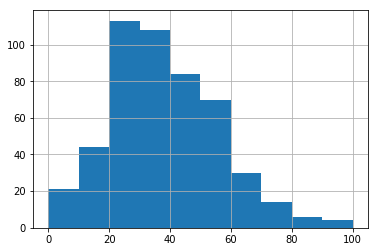

In [8]:
display(d.prop_saida.describe())
d.prop_saida.hist();

Parece que a partir do percentil 75 a _coisa é feia_ pois mais da metade dos professores saíram. 

Onde ficam essas escolas?

count   494.00
mean     23.20
std      15.76
min       1.00
10%       6.00
25%      11.00
50%      19.00
75%      32.00
90%      46.00
max      83.00
Name: CO_PESSOA_FISICA, dtype: float64

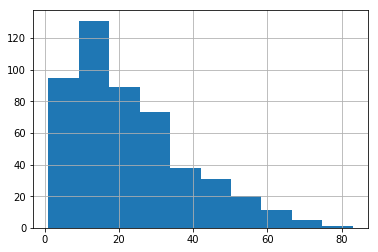

In [9]:
display(d.CO_PESSOA_FISICA.describe([.1,.25,.50,.75,.9]));
d.CO_PESSOA_FISICA.hist();

In [10]:
import folium

In [11]:
lclz_praca_3_poderes = [-15.7994, -47.8613]
map = folium.Map(location=lclz_praca_3_poderes, zoom_start=10)
locations = d.loc[d.CO_PESSOA_FISICA >= 7][['LAT', 'LONG']].head(20)
locationlist = locations.values.tolist()

In [12]:
display(d.loc[d.CO_PESSOA_FISICA >= 7].head(20))
locationlist


,CO_ENTIDADE,target,CO_PESSOA_FISICA,LAT,LONG,dcr,NO_ENTIDADE,CO_ORGAO_REGIONAL,prop_saida
39,53001664,12.00,12,-15.74,-47.90,Brasília*,CEF 316 NORTE,1,100.00
142,53004299,12.00,13,-15.82,-48.09,Taguatinga,CEF 21 DE TAGUATINGA,3,92.31
466,53015541,9.00,10,-15.90,-47.78,Riacho Fundo,CEI 03 DE SAO SEBASTIAO,18,90.00
267,53007727,10.00,12,-15.81,-48.10,Jardim**,EC 12 DE CEILANDIA,8,83.33
139,53004248,14.00,17,-15.81,-48.10,Taguatinga,EC 42 DE TAGUATINGA,3,82.35
162,53005201,9.00,11,-15.61,-48.12,Brazlândia,EC POLO AGRICOLA DA TORRE,4,81.82
3,53000846,8.00,10,-15.81,-47.90,Brasília*,CEF 01 DE BRASILIA,1,80.00
363,53009312,15.00,19,-15.85,-47.95,Paranoá,CEF 01 DA CANDANGOLANDIA,7,78.95
458,53014588,15.00,20,-15.91,-47.76,Riacho Fundo,EC BELA VISTA,18,75.00
26,53001524,6.00,8,-15.74,-47.89,Brasília*,EC 115 NORTE,1,75.00


[[-15.738902358999601, -47.8961599389996],
 [-15.817901298999601, -48.0929510429996],
 [-15.904125592999597, -47.7785940709996],
 [-15.8050091999996, -48.10484145499972],
 [-15.8064864849996, -48.09525081599961],
 [-15.609698454999599, -48.1223619759996],
 [-15.8134506469996, -47.899915633999605],
 [-15.8498777069996, -47.9501539469996],
 [-15.913146797999596, -47.7556934339996],
 [-15.7414110899996, -47.892307356999595],
 [-15.6790440299996, -48.2054488299996],
 [-15.8438864469996, -47.97246563899961],
 [-15.8318985429996, -48.08885317099961],
 [-15.7753419789996, -47.8831179469996],
 [-15.8264468869996, -47.90422259599961],
 [-15.768799452999597, -47.7831692639996],
 [-15.700134967999599, -48.2019363849996],
 [-15.659185897999599, -48.194383589999596],
 [-15.8506638219996, -48.1136286529996],
 [-15.832654795999598, -48.102884660999614]]

Pesquisei essas localizações no Google Maps e as algumas localizações não foram exatas mas deram uma aproximação aceitável (o pior caso ficou 6 quarteirões de distância).

In [14]:
for point in range(0, len(locationlist)):
    folium.Marker(locationlist[point]).add_to(map)
map.save('mapa.html')
map

Pontos de interessantes:
- Como explicar as saídas de escolas do Plano Piloto (Brasília)? Seriam elas exceções? 

Vamos plotar um mapa de calor das 50 piores e ver o que acontece.

In [15]:
#vamos tirar o 100% porque deve ter acontecido alguma coisa com essa escola
data = d.loc[(d.CO_PESSOA_FISICA >= 7) & (d.prop_saida < 100)][['LAT', 'LONG', 'prop_saida']].head(50).values.tolist()


In [17]:
from folium.plugins import HeatMap
m = folium.Map(lclz_praca_3_poderes)
HeatMap(data).add_to(m)
m.save('mapa.html')
m

Mais ou menos como esperado:
    - algumas áreas populosas e mais afastadas do centro estão bem destacadas.
    - Não esperava que o centro de Brasília fosse ter tanto destaque.
    
Assim temos algumas pistas que renda nas imediações nao tem muito a ver (Plano Pilo e Lago Sul). Vamos comprovar  
    

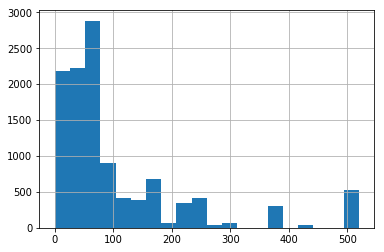

In [18]:
model_vars.MAX_qtd_dom_renda_max_per_mais_5sm.hist(bins=20)

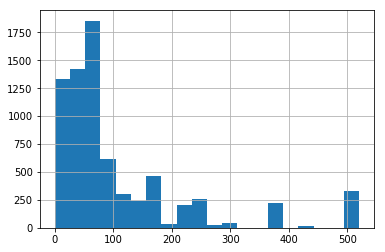

In [19]:
model_vars.loc[model_vars.target == 0].MAX_qtd_dom_renda_max_per_mais_5sm.hist(bins=20);

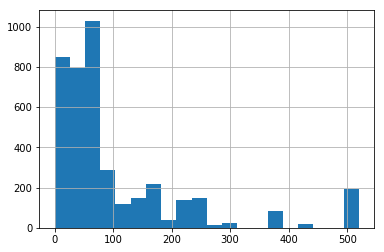

In [20]:
model_vars.loc[model_vars.target == 1].MAX_qtd_dom_renda_max_per_mais_5sm.hist(bins=20);

In [21]:
model_vars[['MAX_qtd_dom_renda_max_per_mais_5sm','target']].corr()

,MAX_qtd_dom_renda_max_per_mais_5sm,target
MAX_qtd_dom_renda_max_per_mais_5sm,1.00,-0.01
target,-0.01,1.00


A correlação diz aquilo que pode-se ver nos gráficos: a renda menor influencia muito pouco na mudança de escola.

#### Vamos ver todas as correlações com a target

In [22]:
cols_alta_correlacao =[]
for l in model_vars.drop('PROF_CO_PESSOA_FISICA',axis=1).set_index(['CO_PESSOA_FISICA','CO_ENTIDADE']).corr()[['target']].sort_values('target',ascending=False).reset_index().itertuples():
    display(str(l[1]) + ' ' + str(l[2]))
    if l[2] < -0.02 or l[2] > 0.02:
        cols_alta_correlacao.append(l[1])

'target 1.0'

'SUM_TURMA_IN_DISC_CIENCIAS 0.09261222130543663'

'SUM_TURMA_IN_TARDE 0.08005528104138582'

'MIN_TURMA_NU_DURACAO_TURMA 0.07182087175945935'

'IN_COMUM_FUND_AF 0.06650883071004288'

'MIN_TURMA_NU_DIAS_ATIVIDADE 0.056514520591229654'

'MAX_TURMA_NU_DURACAO_TURMA 0.05462160505634562'

'MAX_TURMA_NU_DIAS_ATIVIDADE 0.05160206579284069'

'IN_FUNDAMENTAL_CICLOS 0.047974537578467695'

'SUM_TURMA_IN_REGULAR 0.04488581753181263'

'SUM_TURMA_IN_DISC_GEOGRAFIA 0.044549617788217095'

'IN_ESGOTO_FOSSA 0.04440937919045113'

'SUM_TURMA_IN_DISC_LINGUA_INDIGENA 0.04345842553350792'

'SUM_TURMA_IN_DISC_LINGUA_FRANCES 0.04345552940387816'

'SUM_TURMA_IN_DISC_LINGUA_OUTRA 0.04315504599601616'

'SUM_TURMA_IN_DISC_ARTES 0.041380353525988296'

'SUM_TURMA_IN_DISC_HISTORIA 0.04135571967322635'

'SUM_TURMA_IN_DISC_OUTRAS 0.04106790135608206'

'SUM_TURMA_IN_DISC_LIBRAS 0.04089972999164004'

'LAT 0.040247586843958696'

'SUM_TURMA_IN_DISC_LINGUA_INGLES 0.040223397435667975'

'SUM_TURMA_IN_DISC_MATEMATICA 0.03825206326261129'

'SUM_TURMA_IN_DISC_LINGUA_PORTUGUESA 0.03794268090683334'

'MIN_qtd_alugados 0.03685350180922534'

'SUM_TURMA_IN_DISC_EDUCACAO_FISICA 0.0363860517852543'

'SUM_TURMA_IN_MAIS_EDUCACAO 0.035523042452695996'

'TP_ATIVIDADE_COMPLEMENTAR 0.03267320996098882'

'SUM_TURMA_IN_DISC_INFORMATICA_COMPUTACAO 0.031734601596416424'

'SUM_TURMA_IN_DISC_ENSINO_RELIGIOSO 0.031325711833753274'

'ALUNO_COUNT_CO_PESSOA_FISICA 0.03084300084469101'

'SUM_TURMA_IN_DIA_SEMANA_SEXTA 0.02896472768694154'

'SUM_TURMA_NU_DURACAO_TURMA 0.027196425988963605'

'SUM_TURMA_IN_DIA_SEMANA_QUARTA 0.02710463170198497'

'MIN_qtd_quitados 0.025016739008055896'

'MIN_renda_media_dom 0.023329060432318686'

'SUM_TURMA_IN_DIA_SEMANA_TERCA 0.023238682065033243'

'SUM_TURMA_NU_DIAS_ATIVIDADE 0.02305351284513054'

'SUM_TURMA_IN_DIA_SEMANA_SEGUNDA 0.022859504406993605'

'SUM_TURMA_IN_DIA_SEMANA_QUINTA 0.022475408709817304'

'MIN_qtd_pessoas_vizinhos 0.02099274416541413'

'MIN_qtd_dom_vizinhos 0.02032420899821386'

'MIN_qtd_domicilios 0.01956839423396525'

'MIN_qtd_pessoas 0.019561983065471113'

'IN_SALA_LEITURA 0.019347637273053865'

'IN_COMUM_FUND_AI 0.018719484671661818'

'IN_PATIO_COBERTO 0.018618351179201433'

'MIN_qtd_mulheres 0.01822088018798007'

'MIN_qtd_dom_renda_per_cap_abx_1sm_vizinhos 0.017526425519475454'

'NU_EQUIP_RETROPROJETOR_PER_MATRICULA 0.01679031216674425'

'MIN_qtd_mulheres_resp 0.016647480038282987'

'MIN_qtd_pss_abx_12 0.016162116849590565'

'NUM_DD_AULAS 0.015504199814631088'

'MIN_qtd_dom_renda_per_cap_abx_1sm 0.015477286235351502'

'IN_COMUM_EJA_FUND 0.015244383278982218'

'CO_ORGAO_REGIONAL 0.01461218293564707'

'TP_LOCALIZACAO 0.014328682737619669'

'MIN_ALUNO_MEAN_IN_TERRA_NATAL 0.014262821633512566'

'IN_ALMOXARIFADO 0.013992539976706792'

'IN_SALA_ATENDIMENTO_ESPECIAL 0.01310797437115466'

'MAX_ALUNO_MEAN_IN_ONIBUS 0.012837490196809706'

'MAX_qtd_cedidos 0.012345983641812934'

'NU_EQUIP_FOTO_PER_MATRICULA 0.011478929038461027'

'SUM_TURMA_IN_ESPECIAL_EXCLUSIVA 0.009683974799610364'

'NU_EQUIP_DVD_PER_MATRICULA 0.008422843959652206'

'NU_EQUIP_IMPRESSORA_MULT_PER_MATRICULA 0.008364884618625836'

'MAX_qtd_mulheres_resp 0.008274141962498408'

'SUM_TURMA_IN_PROFISSIONALIZANTE 0.008266301692308254'

'IN_BANHEIRO_CHUVEIRO 0.00815192753643313'

'MAX_ALUNO_MEAN_IN_TERRA_NATAL 0.008005163530783897'

'MIN_qtd_pss_acima_65 0.007400185506124178'

'IN_EQUIP_IMPRESSORA_MULT 0.007125830985418084'

'NU_EQUIP_VIDEOCASSETE_PER_MATRICULA 0.006871944717912859'

'IN_EQUIP_RETROPROJETOR 0.0065748430013997956'

'MIN_qtd_dom_renda_max_per_mais_5sm 0.005330517536381227'

'MAX_qtd_dom_renda_per_cap_abx_1sm_vizinhos 0.005030934893731763'

'MAX_qtd_dom_renda_per_cap_abx_1sm 0.004583543968825558'

'MIN_ALUNO_MEAN_IN_ONIBUS 0.0035630178064839264'

'NU_EQUIP_RETROPROJETOR 0.0035578148391586565'

'NU_EQUIP_PARABOLICA_PER_MATRICULA 0.0033040565677306456'

'MIN_DISTANCIA_SETOR_ENTIDADE 0.002981877064258401'

'MAX_ALUNO_MEAN_IN_H0MEM 0.0026598630030241492'

'NU_EQUIP_TV_PER_MATRICULA 0.0024834565511917964'

'SUM_TURMA_IN_EJA 0.0022310351619782144'

'MIN_qtd_em_aquisicao 0.0017953028153837663'

'SUM_TURMA_NU_MATRICULAS 0.0014140159128319077'

'IN_COMUM_PRE 0.0012812761147377649'

'NU_EQUIP_IMPRESSORA_MULT 0.0012796440721678719'

'MAX_qtd_pss_abx_12 0.0011136236083516366'

'MIN_TURMA_NU_MATRICULAS 0.0006904403919098164'

'MAX_qtd_pss_acima_90 -0.0009050896953769108'

'IN_LABORATORIO_CIENCIAS -0.0010716587987392365'

'MIN_ALUNO_MEAN_IN_H0MEM -0.0014080277645395006'

'NU_EQUIP_VIDEOCASSETE -0.0023717613245126433'

'NU_EQUIP_IMPRESSORA_PER_MATRICULA -0.0030093009623367744'

'LONG -0.0036440092211959116'

'IN_BIBLIOTECA -0.003671319454451185'

'SUM_qtd_dom_renda_per_cap_abx_1sm -0.003999218746006085'

'SUM_qtd_dom_renda_per_cap_abx_1sm_vizinhos -0.004444225159081135'

'MAX_TURMA_NU_MATRICULAS -0.006068629919032694'

'MAX_qtd_dom_renda_max_per_mais_5sm -0.0064512343403219955'

'NU_EQUIP_FOTO -0.006610767189514641'

'IN_DESPENSA -0.006968101221948884'

'SUM_qtd_cedidos -0.007287968415365244'

'IN_FINAL_SEMANA -0.007596126839695549'

'MIN_qtd_pss_acima_90 -0.007815043469134876'

'IN_QUADRA_ESPORTES_COBERTA -0.01016047763704136'

'NU_EQUIP_SOM_PER_MATRICULA -0.010309065791535977'

'IN_PARQUE_INFANTIL -0.011050962935593798'

'SUM_qtd_dom_renda_max_per_mais_5sm -0.011141657275385622'

'MAX_renda_media_dom -0.011200406832466345'

'MIN_qtd_cedidos -0.011642247942126063'

'NU_EQUIP_COPIADORA_PER_MATRICULA -0.011790895646366836'

'SUM_qtd_pss_acima_90 -0.01186467759885337'

'PC_SALAS_UTILIZADAS -0.012047851702221522'

'SUM_qtd_pss_abx_12 -0.01276301427557049'

'MAX_qtd_pss_acima_65 -0.013940316817964609'

'IN_EJA -0.014280624450460723'

'NU_EQUIP_SOM -0.014947365198641384'

'SUM_qtd_alugados -0.014961380028733878'

'IN_BIBLIOTECA_SALA_LEITURA -0.015527346024682899'

'MAX_DISTANCIA_SETOR_ENTIDADE -0.015788005223035348'

'SUM_qtd_pss_acima_65 -0.016419195131611077'

'NU_EQUIP_TV -0.016599184983508507'

'IN_ESP_EXCLUSIVA_FUND_AI -0.01745519660787506'

'MAX_qtd_alugados -0.017726300573150052'

'NU_COMP_ALUNO_PER_MATRICULA -0.01783872320303217'

'SUM_qtd_mulheres_resp -0.017993029941834538'

'SUM_qtd_pessoas_vizinhos -0.019055957711275905'

'SUM_qtd_pessoas -0.01920767655638484'

'SUM_qtd_dom_vizinhos -0.019290181271040093'

'SUM_qtd_domicilios -0.019297138033997605'

'IN_PATIO_DESCOBERTO -0.019374218621667025'

'SUM_qtd_quitados -0.019448329308482233'

'SUM_TURMA_IN_DISC_ESTUDOS_SOCIAIS -0.01948092605197646'

'SUM_qtd_mulheres -0.019654414497978487'

'IN_QUADRA_ESPORTES_DESCOBERTA -0.019931370014030655'

'IN_BANHEIRO_EI -0.019951147460941926'

'NU_EQUIP_MULTIMIDIA_PER_MATRICULA -0.02001187891787649'

'NU_EQUIP_DVD -0.020368452345219355'

'NU_EQUIP_FAX_PER_MATRICULA -0.020422433107424063'

'SUM_TURMA_IN_DISC_LINGUA_ESPANHOL -0.020806669451978493'

'IN_QUADRA_ESPORTES -0.021680769685387288'

'MAX_qtd_quitados -0.02199950751378335'

'SUM_TURMA_IN_DISC_FISICA -0.022608034176996004'

'SUM_TURMA_IN_DISC_SOCIOLOGIA -0.02276357479797977'

'MAX_qtd_pessoas -0.02381989323057228'

'MIN_ALUNO_MEAN_NU_IDADE -0.02385543093081482'

'MAX_qtd_pessoas_vizinhos -0.023978615788047174'

'QTD_CO_SETOR_CENSITARIO -0.024311427512385506'

'IN_DEPENDENCIAS_PNE -0.024385730769641553'

'MAX_qtd_domicilios -0.025105403636834375'

'MAX_qtd_dom_vizinhos -0.025105403636834375'

'NU_COMPUTADOR_PER_MATRICULA -0.025813507420059396'

'SUM_TURMA_IN_DISC_QUIMICA -0.02585702648596223'

'SUM_TURMA_IN_DISC_BIOLOGIA -0.02601586831875183'

'IN_COMUM_MEDIO_MEDIO -0.027088049522479028'

'MAX_qtd_mulheres -0.027495169007851004'

'SUM_TURMA_IN_DISC_EST_SOCIAIS_SOCIOLOGIA -0.02775278499317765'

'NU_COMP_ALUNO -0.028138702626557155'

'IN_ESPECIAL_EXCLUSIVA -0.028673886252537896'

'SUM_TURMA_IN_DISC_FILOSOFIA -0.02872741013300437'

'NU_EQUIP_PARABOLICA -0.029441944536583838'

'NU_COMP_ADMINISTRATIVO_PER_MATRICULA -0.029488692598691826'

'NU_PROFESSORES_PER_MATRICULA -0.02968215261785392'

'IN_AREA_VERDE -0.029951037558630066'

'IN_REFEITORIO -0.0304477135704239'

'IN_LABORATORIO_INFORMATICA -0.030489587552969186'

'IN_EQUIP_VIDEOCASSETE -0.03069540215442024'

'IN_BANHEIRO_PNE -0.031526661832979266'

'MAX_ALUNO_MEAN_NU_IDADE -0.0318234475897033'

'IN_EQUIP_FOTO -0.03248514227176294'

'IN_EQUIP_PARABOLICA -0.0337718123490843'

'NU_EQUIP_FAX -0.03684296301334032'

'IN_EQUIP_FAX -0.038688622760372667'

'NU_EQUIP_IMPRESSORA -0.0395901222647585'

'NU_SALAS_EXISTENTES_PER_MATRICULA -0.04251077774743626'

'NU_FUNCIONARIOS_PER_MATRICULA -0.043136660035038736'

'IN_ESGOTO_REDE_PUBLICA -0.04440937919045113'

'NU_SALAS_UTILIZADAS_PER_MATRICULA -0.045229645883492375'

'NU_EQUIP_COPIADORA -0.04813855777841364'

'SUM_TURMA_IN_MANHA -0.048311765161940266'

'SUM_qtd_em_aquisicao -0.05533856182539963'

'NU_COMP_ADMINISTRATIVO -0.05987242895373029'

'IN_AUDITORIO -0.060239851827722006'

'MAX_qtd_em_aquisicao -0.06743679322983907'

'NU_TTL_MATRICLAS -0.06973346556572664'

'NU_EQUIP_MULTIMIDIA -0.06974019590056026'

'NU_COMPUTADOR -0.07017789405131092'

'NU_SALAS_EXISTENTES -0.08505439526428835'

'NU_SALAS_UTILIZADAS -0.08750181181646156'

'NU_FUNCIONARIOS -0.10104218941789399'

### Uma modelagem com Random Forest para verificar as features mais importantes.

array([[1425,  441],
       [ 609,  391]])

Base de TREINO
             precision    recall  f1-score   support

      False       0.92      0.96      0.94      5483
       True       0.92      0.85      0.88      3112

avg / total       0.92      0.92      0.92      8595

Base de TESTE
             precision    recall  f1-score   support

      False       0.70      0.76      0.73      1866
       True       0.47      0.39      0.43      1000

avg / total       0.62      0.63      0.62      2866



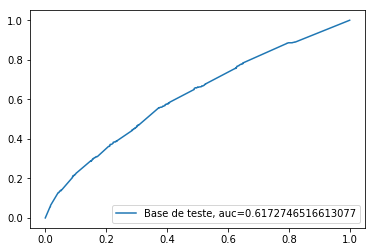

Feature ranking:
1. feature MIN_ALUNO_MEAN_NU_IDADE (0.107470)
2. feature MAX_ALUNO_MEAN_NU_IDADE (0.106204)
3. feature ALUNO_COUNT_CO_PESSOA_FISICA (0.095308)
4. feature SUM_TURMA_IN_MANHA (0.020160)
5. feature SUM_qtd_em_aquisicao (0.016604)
6. feature SUM_TURMA_IN_TARDE (0.016371)
7. feature NU_TTL_MATRICLAS (0.015794)
8. feature NU_COMPUTADOR_PER_MATRICULA (0.015765)
9. feature LAT (0.015400)
10. feature NU_FUNCIONARIOS (0.015331)
11. feature SUM_TURMA_NU_DURACAO_TURMA (0.015269)
12. feature NU_FUNCIONARIOS_PER_MATRICULA (0.015263)
13. feature NU_PROFESSORES_PER_MATRICULA (0.015153)
14. feature NU_COMP_ADMINISTRATIVO_PER_MATRICULA (0.014141)
15. feature NU_COMPUTADOR (0.013942)
16. feature QTD_CO_SETOR_CENSITARIO (0.013803)
17. feature NU_SALAS_UTILIZADAS_PER_MATRICULA (0.013747)
18. feature SUM_TURMA_IN_MAIS_EDUCACAO (0.013633)
19. feature MAX_qtd_em_aquisicao (0.013311)
20. feature NU_SALAS_EXISTENTES_PER_MATRICULA (0.013036)
21. feature NU_EQUIP_MULTIMIDIA_PER_MATRICULA (0.01290

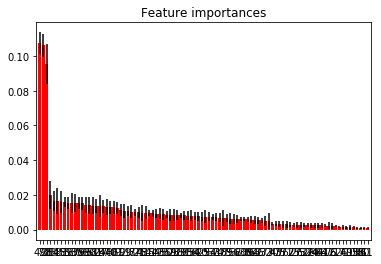

In [23]:
a = processa_tudo(model_vars[cols_alta_correlacao])

array([[1428,  438],
       [ 618,  382]])

Base de TREINO
             precision    recall  f1-score   support

      False       0.92      0.96      0.94      5483
       True       0.92      0.85      0.89      3112

avg / total       0.92      0.92      0.92      8595

Base de TESTE
             precision    recall  f1-score   support

      False       0.70      0.77      0.73      1866
       True       0.47      0.38      0.42      1000

avg / total       0.62      0.63      0.62      2866



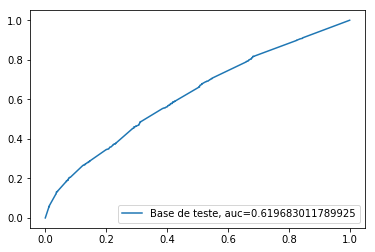

Feature ranking:
1. feature ALUNO_COUNT_CO_PESSOA_FISICA (0.170528)
2. feature MAX_ALUNO_MEAN_NU_IDADE (0.167958)
3. feature MIN_ALUNO_MEAN_NU_IDADE (0.160589)
4. feature LAT (0.087591)
5. feature NU_TTL_MATRICLAS (0.082770)
6. feature NU_FUNCIONARIOS (0.081225)
7. feature SUM_qtd_em_aquisicao (0.078156)
8. feature NU_COMPUTADOR_PER_MATRICULA (0.078091)
9. feature SUM_TURMA_IN_MANHA (0.048767)
10. feature SUM_TURMA_IN_TARDE (0.044324)


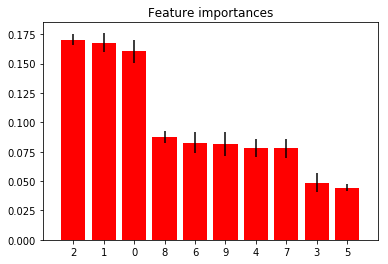

In [24]:
b = processa_tudo(model_vars[a[0][:10]+ ['target']])

array([[1381,  485],
       [ 645,  355]])

Base de TREINO
             precision    recall  f1-score   support

      False       0.86      0.92      0.89      5483
       True       0.84      0.74      0.79      3112

avg / total       0.85      0.86      0.85      8595

Base de TESTE
             precision    recall  f1-score   support

      False       0.68      0.74      0.71      1866
       True       0.42      0.35      0.39      1000

avg / total       0.59      0.61      0.60      2866



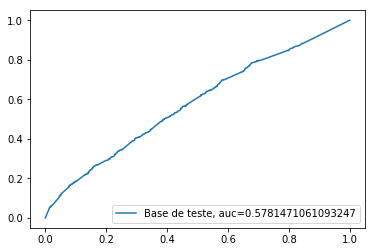

Feature ranking:
1. feature MAX_ALUNO_MEAN_NU_IDADE (0.353423)
2. feature MIN_ALUNO_MEAN_NU_IDADE (0.339134)
3. feature ALUNO_COUNT_CO_PESSOA_FISICA (0.307443)


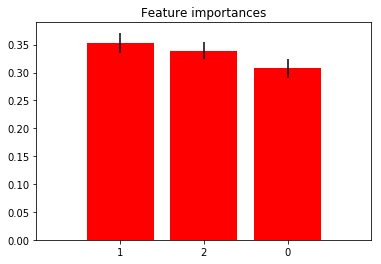

In [25]:
b = processa_tudo(model_vars[b[0][:3]+ ['target']])

<img src='https://media.giphy.com/media/3o6Mb2JwJPVu7VMDSw/giphy.gif'/>

#### Esse resultado está muito ruim (claramente com _overfitting_), vamos fazer uns ajustes com cross validation e grid search.

RandomizedSearchCV took 2.29 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.582 (std: 0.014)
Parameters: {'bootstrap': False, 'criterion': 'entropy', 'max_depth': None, 'max_features': 8, 'min_samples_leaf': 7, 'min_samples_split': 10}

Model with rank: 2
Mean validation score: 0.568 (std: 0.016)
Parameters: {'bootstrap': False, 'criterion': 'gini', 'max_depth': None, 'max_features': 5, 'min_samples_leaf': 6, 'min_samples_split': 3}

Model with rank: 3
Mean validation score: 0.567 (std: 0.021)
Parameters: {'bootstrap': False, 'criterion': 'gini', 'max_depth': None, 'max_features': 9, 'min_samples_leaf': 8, 'min_samples_split': 10}

GridSearchCV took 23.77 seconds for 216 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.579 (std: 0.023)
Parameters: {'bootstrap': False, 'criterion': 'entropy', 'max_depth': None, 'max_features': 10, 'min_samples_leaf': 10, 'min_samples_split': 2}

Model with rank: 1
Mean validation score:

array([[873, 153],
       [157, 873]])

Base de TREINO
             precision    recall  f1-score   support

      False       0.57      0.58      0.58      3086
       True       0.58      0.57      0.57      3082

avg / total       0.58      0.58      0.58      6168

Base de TESTE
             precision    recall  f1-score   support

      False       0.85      0.85      0.85      1026
       True       0.85      0.85      0.85      1030

avg / total       0.85      0.85      0.85      2056



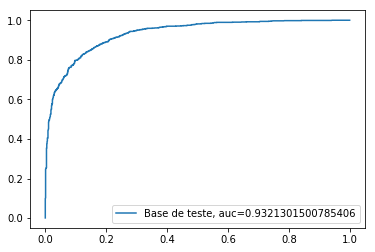

Feature ranking:
1. feature ALUNO_COUNT_CO_PESSOA_FISICA (0.035478)
2. feature MIN_ALUNO_MEAN_NU_IDADE (0.028214)
3. feature SUM_TURMA_NU_MATRICULAS (0.022145)
4. feature SUM_TURMA_IN_TARDE (0.020109)
5. feature MIN_ALUNO_MEAN_IN_H0MEM (0.018700)
6. feature MAX_ALUNO_MEAN_IN_H0MEM (0.018501)
7. feature NU_COMP_ADMINISTRATIVO (0.017985)
8. feature MAX_ALUNO_MEAN_NU_IDADE (0.017009)
9. feature MAX_DISTANCIA_SETOR_ENTIDADE (0.015327)
10. feature MAX_TURMA_NU_MATRICULAS (0.015277)
11. feature NU_EQUIP_MULTIMIDIA (0.015107)
12. feature NU_TTL_MATRICLAS (0.015091)
13. feature NU_COMPUTADOR (0.014572)
14. feature SUM_TURMA_IN_MANHA (0.014442)
15. feature NU_EQUIP_RETROPROJETOR_PER_MATRICULA (0.013531)
16. feature MIN_TURMA_NU_MATRICULAS (0.013076)
17. feature MAX_ALUNO_MEAN_IN_TERRA_NATAL (0.012647)
18. feature NU_PROFESSORES_PER_MATRICULA (0.012228)
19. feature SUM_qtd_cedidos (0.011941)
20. feature NU_SALAS_UTILIZADAS (0.011607)
21. feature MAX_qtd_pss_abx_12 (0.010943)
22. feature NU_EQUIP

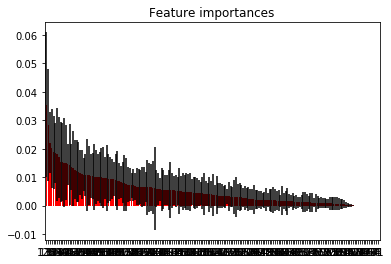

In [30]:
cols_drop = ['PROF_CO_PESSOA_FISICA','NO_ENTIDADE','dcr','LAT','LONG']
a = processa_tudo(model_vars.drop(cols_drop,axis=1).set_index(['CO_PESSOA_FISICA','CO_ENTIDADE']),True),

In [31]:
fi = a[0][0]
clf = a[0][1]

RandomizedSearchCV took 3.66 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.601 (std: 0.020)
Parameters: {'bootstrap': False, 'criterion': 'entropy', 'max_depth': None, 'max_features': 10, 'min_samples_leaf': 9, 'min_samples_split': 7}

Model with rank: 2
Mean validation score: 0.587 (std: 0.036)
Parameters: {'bootstrap': False, 'criterion': 'entropy', 'max_depth': None, 'max_features': 5, 'min_samples_leaf': 3, 'min_samples_split': 2}

Model with rank: 3
Mean validation score: 0.585 (std: 0.026)
Parameters: {'bootstrap': False, 'criterion': 'gini', 'max_depth': None, 'max_features': 9, 'min_samples_leaf': 8, 'min_samples_split': 5}

Model with rank: 3
Mean validation score: 0.585 (std: 0.020)
Parameters: {'bootstrap': False, 'criterion': 'entropy', 'max_depth': None, 'max_features': 6, 'min_samples_leaf': 8, 'min_samples_split': 7}

GridSearchCV took 29.93 seconds for 216 candidate parameter settings.
Model with rank: 1
Mean validation score:

array([[991,  35],
       [ 40, 990]])

Base de TREINO
             precision    recall  f1-score   support

      False       0.56      0.57      0.57      3086
       True       0.57      0.56      0.56      3082

avg / total       0.56      0.56      0.56      6168

Base de TESTE
             precision    recall  f1-score   support

      False       0.96      0.97      0.96      1026
       True       0.97      0.96      0.96      1030

avg / total       0.96      0.96      0.96      2056



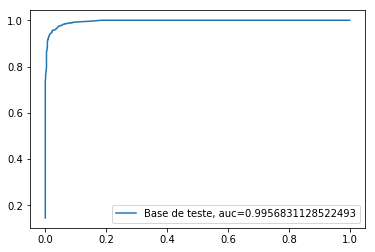

Feature ranking:
1. feature MAX_ALUNO_MEAN_NU_IDADE (0.048634)
2. feature MIN_ALUNO_MEAN_NU_IDADE (0.042083)
3. feature MAX_ALUNO_MEAN_IN_H0MEM (0.041435)
4. feature MIN_ALUNO_MEAN_IN_H0MEM (0.037651)
5. feature SUM_TURMA_NU_MATRICULAS (0.036886)
6. feature MAX_ALUNO_MEAN_IN_TERRA_NATAL (0.034592)
7. feature ALUNO_COUNT_CO_PESSOA_FISICA (0.033058)
8. feature MIN_ALUNO_MEAN_IN_TERRA_NATAL (0.030249)
9. feature MAX_TURMA_NU_MATRICULAS (0.029335)
10. feature NU_PROFESSORES_PER_MATRICULA (0.027801)
11. feature MIN_TURMA_NU_MATRICULAS (0.027115)
12. feature SUM_TURMA_IN_MANHA (0.025671)
13. feature SUM_TURMA_IN_DISC_CIENCIAS (0.024146)
14. feature NU_COMPUTADOR_PER_MATRICULA (0.022111)
15. feature MAX_DISTANCIA_SETOR_ENTIDADE (0.021933)
16. feature NU_EQUIP_MULTIMIDIA_PER_MATRICULA (0.021616)
17. feature NU_FUNCIONARIOS (0.019995)
18. feature NU_SALAS_UTILIZADAS_PER_MATRICULA (0.019774)
19. feature NU_TTL_MATRICLAS (0.019481)
20. feature NU_COMPUTADOR (0.018726)
21. feature SUM_TURMA_IN_DIS

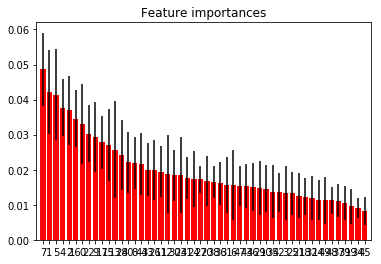

In [32]:
md_b = model_vars.set_index(['CO_PESSOA_FISICA','CO_ENTIDADE'])[fi[:50] + ['target']]
b = processa_tudo(md_b,True),

In [33]:
clf = b[0][1]

### Consideracoes:
01. Com Grid Search a performance melhora consideravelmente.

02. O resultado retirando uma amostra da base para balancear (com o ```sample``` do pandas ) ficou estranho, resultado muito bom no teste e ruim no treino e quando aplica-se a todo o dataset.

### Com esse resultado estamos assim:
<!--
<img src='img/homer-simpson-woohoo-gif-6.gif'/>
-->

## Primeiro, vamos analisar quando o classificador erra.

In [34]:
y_true = md_b.target
X = md_b.drop('target',axis=1).values
y_pred = clf.predict(X)
lc = [c for y1,y2,c in zip(y_true,y_pred,md_b.index) if y1 != y2]

In [ ]:
1 - len(lc)/len(md_b.index)